BEFORE WE START...
--------------

The VM needs a patch to perform some of this analysis. Applying the patch is relatively painless. You will need to stop your VM in order to activate the patch.

Go to the [ssvm](https://github.com/FermiSummerSchool/ssvm) portion of github and follow the directions at the bottom under **Tempo2/PGPLOT patch instructions** to install the patch. 

Once that's done, you can restart your VM and run jupyter to follow along with this notebook.

Pulsar Analysis with FermiPy
===========================

Pulsars display both temporal and spectral signatures in LAT data. However, the periodicity for gamma-ray pulsars is much faster than the frequency at which photons are detected by the LAT. 

The Vela pulsar, the brightest persistent source in the LAT sky, produces (on average) one LAT event every 2.6 minutes. During that time, the pulsar has rotated ~1766 times...emitting a radio pulse each time. These radio pulses provide a signal that can be easily used to characterize the pulsar.

While a number of pulsars have been discovered pulsing in the LAT gamma-ray data, the analysis required for that discovery is complex and requires significant computing power. 

* Here we will discuss what can be done with pulsars that have already been detected and characterized for timing. 
 
Once the timing solution for a pulsar has been found, it opens the door to analysis in the gamma-rays. In order to leverage this knowledge, we first need a timing model that is valid during at least part of the Fermi mission. The easiest place to look is the most recent [Pulsar Catalog](https://fermi.gsfc.nasa.gov/ssc/data/access/lat/2nd_PSR_catalog/), which includes all the pulsar timing files that were used in the process of developing the catalog. 

Also see [the LAT Gamma-ray Pulsar Timing Model page](https://confluence.slac.stanford.edu/display/GLAMCOG/LAT+Gamma-ray+Pulsar+Timing+Models) to find automated timing solutions for pulsars that can be timed using the gamma-ray data. 

Overview of steps
===================

1) Perform Binned Likelihood analysis to make a best-fit spectral model of the pulsar region. This can take a while, depending on how much data you are analyzing.

2) Use the likelihood fit results you can assign each photon in the region a probability that it is associated with the source you are analyzing. You could remove photons with low probabilities to enhance the pulsar signal. Or even better, you can weight the photons by their probability of association to enhance the sensitivity of the timing analysis.

3) Apply the timing model for the pulsar to the data and look for pulsations


Get the timing model
--------------

Download the 2PC catalog archive into your working directory and untar/zip it or download the appropriate par file from the LAT gamma-ray pulsar timing page.

In [1]:
from IPython.display import HTML

In [3]:
HTML("<iframe src='https://fermi.gsfc.nasa.gov/ssc/data/access/lat/2nd_PSR_catalog/' width='850' height='500'></iframe>")

Once you have unzipped/untarred the archive you should find the timing files under 2PC_auxiliary_files_v04/par_files . You should look at the .par file for your source of interest to determine the validity interval for the timing solution.

In [5]:
cat 2PC_auxiliary_files_v04/par_files/PSRJ0835-4510_2PC.par

PSRJ           J0835-4510
RAJ            08:35:20.6014180  1494095889877278279196967348960916383303068297681337500578843582907075250553170225064932249483620888887236231168.00000000000000000000
DECJ           -45:10:34.81100  19099631298631109784835146042022771335484276116063150918714795143707197181702597070494097091739463025361450901761261876054083020794361316684857344.00000000000000000000
F0             11.1900618030328178  0.00000000178435155659
F1             -1.556663416301537142e-11  3.0924539030839694191e-17
F2             6.3045349816314820855e-22  4.1955168655815663352e-23
F3             -3.4774910216538983914e-29  5.961363058196945971e-31
F4             -7.5540038297028344005e-37  9.7546508400540024772e-37
F5             4.4083825499489473231e-43  1.0917930928516011952e-44
F6             3.262925760894881608e-50  1.9822294724994367946e-50
F7             -4.0141431700222901303e-57  1.5337423675229011619e-58
F8             -5.2619122458828113307e-64  3.0416162415893077421e-64
F9

This is the Vela pulsar and has timing information available in this file from MJD 54207 (before Fermi's launch) to MJD 55793, in April of 2010.

Let's look at the file from the gamma-ray timing page.

In [6]:
cat J0835-4510_54683_56587_chol.par

PSRJ                J0835-4510                
# from Dodson et al. 2003, VLBI observations 
RAJ     08:35:20.61149
DECJ     -45:10:34.8751
PMRA                -49.68                    0.06                      
PMDEC               29.9                      0.1                       
PX                  3.5                       0.2                       
# the reference epoch given in Dodson et al. is 2000.0 
POSEPOCH            51544                     
F0                  11.189322019611838144     0  4.1477577576998214681e-06 
F1                  -1.5503871865717438666e-11 0  2.0969674074348013432e-14 
PEPOCH              55555                     
DM                  67.989999999999999998     
GLEP_1              55408.800000000000001     
GLEP_2              56555.808277056879888     
GLPH_1              0.0016241904377657749491  
GLPH_2              0.81609646827025394966    
GLF0_1              2.123446824495564662e-05  
GLF0_2              3.4283334667081729913e-05 
GLF1_1   

The gamma-ray timing solution covers a larger range of time, from MJD 54686 (Aug. 8, 2008) to MJD 56583 (Oct. 18, 2013). It starts a few days after science operations began.

**The 2PC Catalog has a huge amount of useful information, including:**

* An overview FITS file that summarizes the content of the paper tables for each pulsar
* Timing parameter files for all the pulsars in the catalog
* Plots showing the radio and gamma-ray light curves, the best-fit gamma-ray light curve, and the gamma-ray light curves in different energy ranges
* Plots showing the results of the spectral analysis, with the best-fit model overplotted on the individual spectral points
* Individual FITS (and ascii) files for each pulsar that include the data points and errors used for:
    * all the gamma-ray light curves
    * the best-fit gamma-ray light curve
    * the radio light curve
    * the individual spectral points
    * the best-fit spectral model
    
This is an excellent archive for preparing for publications. I encourage you to take a look at the contents.

Get the LAT data for your pulsar
---------------------

Now we need the data for the pulsar. This pulsar is close to the plane of the Galaxy (b=-2.79), which means characterizing the diffuse emission will be important for our analysis. I downloaded data for a 20-degree ROI from the beginning of science operations (Aug. 4, 2008) until about 6 months later. In my lanalysis configuration, I will need to choose a start and stop time within the validity period for the timing solution that I use.

In [7]:
ls data

events.txt                         L2306042305074ABB9C6321_PH01.fits
L2306042305074ABB9C6321_PH00.fits  L2306042305074ABB9C6321_SC00.fits


Remember that the download selection information is stored in the header of the data files and can be viewed with *[gtvcut](http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtvcut.txt)*.

In [28]:
ls data/*PH* > data/events.txt

In [8]:
cat data/events.txt

L2306042305074ABB9C6321_PH00.fits
L2306042305074ABB9C6321_PH01.fits


As a rule, the E-dot (spindown power) for a pulsar needs to be greater than about 10^33 for it to have a chance of being detected in the gamma rays. Below that threshold, it is speculated, there is not enough energy in the system to spawn the processes that generate gamma rays. 

![PPdot](images/P-Pdot.gif)

The first step of searching in gamma rays for a pulsar with a known radio ephemeris is to determine if that source is even a pulsed gamma-ray source. To determine that, you should extract the photons associated with that pulsar...

How do we know which photons are related to a particular source?

Likelihood tells us which events have a higher probability of coming from a source in the model... and which do not. You may be tempted select a small region near the known pulsar position to cut out background. However, the better solution is to use all the information you have to improve your analysis. This means completing a likelihood fit prior to attempting any timing analysis. The benefits to this approach are:

1) You determine if the source is detected significantly enough to provide spectral information. If the pulsar isn't signiicant, then the timing information is the only thing you can use. 

2) A successful spectral fit allows you to run *[gtsrcprob](http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtsrcprob.txt)* which allows you to weight your data set to favor events that are more likely to have originated from the pulsar.

Initial Spectral Analysis
-----------------

Many energetic young radio pulsars are faint in gamma rays, likely due to geometry...the part of the magnetosphere that produces radio emission only partially overlaps with the part that produces gamma rays. The same is true for bright young gamma-ray pulsars...nearly all the new pulsars discovered in the gamma rays are completely radio quiet. 

![PSR_regions](images/PSR_emission_regions.png)

This is not the case for recycled pulsars. In pulsars with millisecond periods, the two emission regions appear to have much more overlap.

Vela is very bright, it's the brightest steady source of gamma rays in the LAT energy band. Many other pulsars are faint. They can require careful treatment for gamma-ray spectral analysis. The spectral fit for a faint source will be affected if nearby, brighter sources are not properly modeled. This means you will need to free more parameters in your model to ensure a good fit for bright sources in the region. This will make the spectral fit take a little longer.

Let's first perform a binned likelihood analysis to characterize the sources in our ROI.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [10]:
ls

2PC_auxiliary_files_v04/     data/
2PC_auxiliary_files_v04.tgz  J0835-4510_54683_56587_chol.par
config.yaml                  Pulsar_Analysis_with_FermiPy.ipynb
config.yaml~                 readme.txt


In [11]:
cat config.yaml

data:
  evfile : data/events.txt
  scfile : data/SC00.fits

binning:
  roiwidth   : 15.0
  binsz      : 0.1
  binsperdec : 8

selection :
  emin : 100
  emax : 100000
  zmax    : 90
  evclass : 128
  evtype  : 3
  tmin    : 239889601 # MJD 54686.5
  tmax    : 255398400 # MJD 54865.99
  filter  : 'DATA_QUAL>0 && LAT_CONFIG==1'
  target : 'Vela'  # PSR J0835-4510

gtlike:
  edisp : True
  edisp_bins : -1
  irfs : 'P8R3_SOURCE_V3'
  edisp_disable : ['isodiff']

model:
  src_roiwidth : 20.0
  galdiff  : '$CONDA_PREFIX/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits'
  isodiff  : 'iso_P8R3_SOURCE_V3_v1.txt'
  catalogs : ['4FGL-DR3']

components:
  - { selection : { evtype : 4  } } # PSF0
  - { selection : { evtype : 8  } } # PSF1
  - { selection : { evtype : 16 } } # PSF2
  - { selection : { evtype : 32 } } # PSF3

optimizer:
#   tol : 0.01

fileio:
   outdir : data


In [12]:
from fermipy.gtanalysis import GTAnalysis

In [14]:
gta = GTAnalysis('config.yaml',logging={'verbosity' : 3})

2023-06-05 04:05:03 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 1.2.0 
ScienceTools version 2.2.0


**Run the Analysis Setup script**

This will generate all the input data files needed for the Likelihood fit. 

In [16]:
gta.setup()

2023-06-05 04:06:29 INFO    GTAnalysis.setup(): Running setup.
2023-06-05 04:06:29 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2023-06-05 04:06:29 INFO    GTBinnedAnalysis.run_gtapp(): Running gtselect.
2023-06-05 04:06:29 INFO    GTBinnedAnalysis.run_gtapp(): time -p gtselect infile=/data/PulsarTutorial/data/evfile_00.txt outfile=/data/PulsarTutorial/data/ft1_00.fits ra=128.83700561523438 dec=-45.1781005859375 rad=11.106601717798213 tmin=239889601.0 tmax=255398400.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=4 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=3 clobber=yes debug=no gui=no mode="ql"
2023-06-05 04:06:29 INFO    GTBinnedAnalysis.run_gtapp(): This is gtselect version HEAD
2023-06-05 04:06:29 INFO    GTBinnedAnalysis.run_gtapp(): Applying filter string: ((EVENT_CLASS&o200) != o0) && angsep(RA,DEC,128.8370056,-45.17810059) < 11.10660172 && ((EVENT_TYPE&o4) != o0) && 100 < ENERGY && ENERGY <= 100000 && 239889601 < TIME &&

2023-06-05 04:16:44 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0822.1-4253e
2023-06-05 04:16:44 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0853.1-4407
2023-06-05 04:16:44 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0854.8-4504
2023-06-05 04:16:44 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0854.9-4426
2023-06-05 04:16:44 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0850.8-4239
2023-06-05 04:16:44 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0822.8-4207
2023-06-05 04:16:44 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0853.6-4306
2023-06-05 04:16:44 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0840.5-4122c
2023-06-05 04:16:44 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0823.7-4838
2023-06-05 04:16:44 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0857.0-4353c
2023-06-05 04:16:

2023-06-05 04:16:47 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0741.0-5226 25....................!
2023-06-05 04:16:48 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0741.2-5140 25....................!
2023-06-05 04:16:48 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0741.4-4709 25....................!
2023-06-05 04:16:49 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0741.9-4157 25....................!
2023-06-05 04:16:49 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0742.9-5242 25....................!
2023-06-05 04:16:50 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0743.3-4912c 25....................!
2023-06-05 04:16:51 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0744.9-4028 25....................!
2023-06-05 04:16:51 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0746.5-4113 25....................!

2023-06-05 04:18:36 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0856.4-5309 25....................!
2023-06-05 04:18:37 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0857.0-4353c 25....................!
2023-06-05 04:18:37 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0857.7-4256c 25....................!
2023-06-05 04:18:38 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0858.4-4615c 25....................!
2023-06-05 04:18:39 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0859.2-4729 25....................!
2023-06-05 04:18:40 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0859.3-4342 25....................!
2023-06-05 04:18:40 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0859.8-4530c 25....................!
2023-06-05 04:18:41 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0900.2-4608 25..................

2023-06-05 04:38:09 INFO    GTBinnedAnalysis.run_gtapp(): Computing binned exposure map....................!
2023-06-05 04:38:16 INFO    GTBinnedAnalysis.run_gtapp(): Finished gtexpcube2. Execution time: 10.02 s
2023-06-05 04:38:16 INFO    GTBinnedAnalysis.run_gtapp(): Running gtexpcube2.
2023-06-05 04:38:16 INFO    GTBinnedAnalysis.run_gtapp(): time -p gtexpcube2 infile=/data/PulsarTutorial/data/ltcube_01.fits cmap=none outfile=/data/PulsarTutorial/data/bexpmap_roi_01.fits irfs="P8R3_SOURCE_V3" evtype=8 edisp_bins=0 nxpix=150 nypix=150 binsz=0.1 coordsys="CEL" xref=128.83700561523438 yref=-45.1781005859375 axisrot=0.0 proj="CAR" ebinalg="LOG" emin=100.0 emax=100000.0 enumbins=24 ebinfile="NONE" hpx_ordering_scheme="RING" hpx_order=6 bincalc="EDGE" ignorephi=no thmax=180.0 thmin=0.0 table="EXPOSURE" chatter=3 clobber=yes debug=no mode="ql"
2023-06-05 04:38:16 INFO    GTBinnedAnalysis.run_gtapp(): This is gtexpcube2 version HEAD
2023-06-05 04:38:16 INFO    GTBinnedAnalysis.run_gtapp(): 

2023-06-05 04:38:25 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0911.0-5047
2023-06-05 04:38:25 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0817.7-5258c
2023-06-05 04:38:25 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0918.9-4904c
2023-06-05 04:38:25 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0803.5-5145c
2023-06-05 04:38:25 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0856.4-5309
2023-06-05 04:38:25 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0746.6-4754
2023-06-05 04:38:25 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0853.1-3657
2023-06-05 04:38:25 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0751.6-5029c
2023-06-05 04:38:25 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0754.9-3953
2023-06-05 04:38:25 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0747.5-4927
2023-06-05 04:38

2023-06-05 04:38:54 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0833.3-4342c 25....................!
2023-06-05 04:38:55 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0833.8-4400 25....................!
2023-06-05 04:39:36 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0834.3-4542e 25....................!
2023-06-05 04:39:37 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0835.3-4510 25....................!
2023-06-05 04:39:37 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0836.0-5458 25....................!
2023-06-05 04:39:38 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0837.8-4048c 25....................!
2023-06-05 04:39:39 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0838.4-3952 25....................!
2023-06-05 04:39:39 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0840.5-4122c 25..................

2023-06-05 04:49:41 INFO    GTBinnedAnalysis.setup(): Running setup for component 02
2023-06-05 04:49:41 INFO    GTBinnedAnalysis.run_gtapp(): Running gtselect.
2023-06-05 04:49:41 INFO    GTBinnedAnalysis.run_gtapp(): time -p gtselect infile=/data/PulsarTutorial/data/evfile_02.txt outfile=/data/PulsarTutorial/data/ft1_02.fits ra=128.83700561523438 dec=-45.1781005859375 rad=11.106601717798213 tmin=239889601.0 tmax=255398400.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=16 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=3 clobber=yes debug=no gui=no mode="ql"
2023-06-05 04:49:41 INFO    GTBinnedAnalysis.run_gtapp(): This is gtselect version HEAD
2023-06-05 04:49:41 INFO    GTBinnedAnalysis.run_gtapp(): Applying filter string: ((EVENT_CLASS&o200) != o0) && angsep(RA,DEC,128.8370056,-45.17810059) < 11.10660172 && ((EVENT_TYPE&o20) != o0) && 100 < ENERGY && ENERGY <= 100000 && 239889601 < TIME && TIME <= 255398400 && 0 < ZENITH_ANGLE && ZENITH_ANGLE <= 90 

2023-06-05 05:00:02 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0854.9-4426
2023-06-05 05:00:02 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0850.8-4239
2023-06-05 05:00:02 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0822.8-4207
2023-06-05 05:00:02 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0853.6-4306
2023-06-05 05:00:02 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0840.5-4122c
2023-06-05 05:00:02 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0823.7-4838
2023-06-05 05:00:02 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0857.0-4353c
2023-06-05 05:00:02 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0858.4-4615c
2023-06-05 05:00:02 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0847.8-4138
2023-06-05 05:00:02 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0856.0-4724c
2023-06-05 05:00

2023-06-05 05:00:07 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0741.4-4709 25....................!
2023-06-05 05:00:08 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0741.9-4157 25....................!
2023-06-05 05:00:08 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0742.9-5242 25....................!
2023-06-05 05:00:09 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0743.3-4912c 25....................!
2023-06-05 05:00:09 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0744.9-4028 25....................!
2023-06-05 05:00:10 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0746.5-4113 25....................!
2023-06-05 05:00:10 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0746.6-4754 25....................!
2023-06-05 05:00:11 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0747.5-4927 25....................!

2023-06-05 05:01:37 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0854.9-4426 25....................!
2023-06-05 05:01:38 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0856.0-4724c 25....................!
2023-06-05 05:01:38 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0856.4-5309 25....................!
2023-06-05 05:01:39 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0857.0-4353c 25....................!
2023-06-05 05:01:40 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0857.7-4256c 25....................!
2023-06-05 05:01:40 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0858.4-4615c 25....................!
2023-06-05 05:01:41 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0859.2-4729 25....................!
2023-06-05 05:01:42 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0859.3-4342 25..................

2023-06-05 05:23:42 INFO    GTBinnedAnalysis.run_gtapp(): This is gtexpcube2 version HEAD
2023-06-05 05:23:42 INFO    GTBinnedAnalysis.run_gtapp(): ResponseFunctions::load: IRF used: P8R3_SOURCE_V3 (PSF)
2023-06-05 05:23:42 INFO    GTBinnedAnalysis.run_gtapp(): event_types:  5
2023-06-05 05:23:45 INFO    GTBinnedAnalysis.run_gtapp(): Computing binned exposure map....................!
2023-06-05 05:23:52 INFO    GTBinnedAnalysis.run_gtapp(): Finished gtexpcube2. Execution time: 10.44 s
2023-06-05 05:23:52 INFO    GTBinnedAnalysis.run_gtapp(): Running gtexpcube2.
2023-06-05 05:23:52 INFO    GTBinnedAnalysis.run_gtapp(): time -p gtexpcube2 infile=/data/PulsarTutorial/data/ltcube_03.fits cmap=none outfile=/data/PulsarTutorial/data/bexpmap_roi_03.fits irfs="P8R3_SOURCE_V3" evtype=32 edisp_bins=0 nxpix=150 nypix=150 binsz=0.1 coordsys="CEL" xref=128.83700561523438 yref=-45.1781005859375 axisrot=0.0 proj="CAR" ebinalg="LOG" emin=100.0 emax=100000.0 enumbins=24 ebinfile="NONE" hpx_ordering_sch

2023-06-05 05:24:01 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0911.0-5047
2023-06-05 05:24:01 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0817.7-5258c
2023-06-05 05:24:01 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0918.9-4904c
2023-06-05 05:24:01 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0803.5-5145c
2023-06-05 05:24:01 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0856.4-5309
2023-06-05 05:24:01 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0746.6-4754
2023-06-05 05:24:01 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0853.1-3657
2023-06-05 05:24:01 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0751.6-5029c
2023-06-05 05:24:01 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0754.9-3953
2023-06-05 05:24:01 INFO    GTBinnedAnalysis.run_gtapp(): Creating source named 4FGL J0747.5-4927
2023-06-05 05:24

2023-06-05 05:24:35 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0833.3-4342c 25....................!
2023-06-05 05:24:35 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0833.8-4400 25....................!
2023-06-05 05:25:14 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0834.3-4542e 25....................!
2023-06-05 05:25:15 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0835.3-4510 25....................!
2023-06-05 05:25:16 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0836.0-5458 25....................!
2023-06-05 05:25:16 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0837.8-4048c 25....................!
2023-06-05 05:25:17 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0838.4-3952 25....................!
2023-06-05 05:25:18 INFO    GTBinnedAnalysis.run_gtapp(): Generating SourceMap for 4FGL J0840.5-4122c 25..................

2023-06-05 05:35:28 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2023-06-05 05:35:38 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 01.


Drm_Cache::update Measured counts < 0 4FGL J0850.8-4239 23 -1.42186e-13 8.11689e-12
4.12868 6.69841 8.79938 9.51216 8.76182 7.04479 4.9139 2.99921 1.60137 0.737104 0.290892 0.100212 0.029816 0.00780402 0.00177273 0.000359948 6.36986e-05 9.76841e-06 1.30903e-06 1.54579e-07 1.60604e-08 1.45871e-09 1.15794e-10 8.11689e-12 


2023-06-05 05:35:49 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 02.
2023-06-05 05:35:59 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 03.
2023-06-05 05:36:13 INFO    GTAnalysis.setup(): Initializing source properties
2023-06-05 05:36:21 INFO    GTAnalysis.setup(): Finished setup.


Check your data to be sure the input files make sense. For example, take a look at the counts cube using a fits viewer.

Now let's check the input ROI model.

In [18]:
gta.print_roi()

2023-06-05 10:45:02 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J0835.3-4510   PointSource    PLSuperExpCuto    0.000       nan    123762.8
4FGL J0834.3-4542e  SpatialMap     PowerLaw          0.548       nan      2402.3
4FGL J0830.5-4451   PointSource    LogParabola       0.899       nan       246.9
4FGL J0833.8-4400   PointSource    PowerLaw          1.198       nan       349.2
4FGL J0828.4-4444   PointSource    LogParabola       1.303       nan        54.6
4FGL J0833.3-4342c  PointSource    PowerLaw          1.507       nan       159.1
4FGL J0832.2-4322c  PointSource    PowerLaw          1.894       nan       187.8
4FGL J0844.1-4330   PointSource    LogParabola       2.287       nan       171.6
4FGL J0848.2-4527   PointSource    PowerLaw          2.293       nan       175.4
4FGL J0849.2-4410c  PointSource    PowerLaw          2.6

**Optimize the RoI**

In [19]:
opt1 = gta.optimize()

2023-06-05 10:45:43 INFO    GTAnalysis.optimize(): Starting


Joint fit  ['4FGL J0835.3-4510', 'galdiff', 'isodiff']


/opt/anaconda/envs/fermi/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Fitting shape 4FGL J0835.3-4510 TS: 369769.887
Fitting shape galdiff TS: 211995.076
Fitting shape 4FGL J0822.1-4253e TS:    162.688
Fitting shape isodiff TS:    130.799
Fitting shape 4FGL J0851.9-4620e TS:    104.439
Fitting shape 4FGL J0834.3-4542e TS:     57.492
Fitting shape 4FGL J0911.0-5047 TS:     52.245
Fitting shape 4FGL J0854.8-4504 TS:     41.445
Fitting shape 4FGL J0830.5-4451 TS:     29.586
Fitting shape 4FGL J0827.6-3735 TS:     29.132


2023-06-05 10:48:24 INFO    GTAnalysis.optimize(): Finished
2023-06-05 10:48:24 INFO    GTAnalysis.optimize(): LogLike: -392615.643474 Delta-LogLike: 101.795183
2023-06-05 10:48:24 INFO    GTAnalysis.optimize(): Execution time: 160.88 s


In [20]:
opt1

{'loglike0': -392717.4386568563,
 'loglike1': -392615.64347412065,
 'dloglike': 101.79518273565918,
 'config': {'npred_threshold': 1.0,
  'npred_frac': 0.95,
  'shape_ts_threshold': 25.0,
  'max_free_sources': 5,
  'skip': [],
  'optimizer': {'optimizer': 'MINUIT',
   'tol': 0.001,
   'max_iter': 100,
   'init_lambda': 0.0001,
   'retries': 3,
   'min_fit_quality': 2,
   'verbosity': 0}}}

In [21]:
gta.print_roi()

2023-06-05 10:49:00 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J0835.3-4510   PointSource    PLSuperExpCuto    0.000 444897.67    122578.7
4FGL J0834.3-4542e  SpatialMap     PowerLaw          0.548     64.17      2122.9
4FGL J0830.5-4451   PointSource    LogParabola       0.899     31.32        47.0
4FGL J0833.8-4400   PointSource    PowerLaw          1.198      0.77       185.8
4FGL J0828.4-4444   PointSource    LogParabola       1.303      1.41        25.4
4FGL J0833.3-4342c  PointSource    PowerLaw          1.507      2.49       200.9
4FGL J0832.2-4322c  PointSource    PowerLaw          1.894     11.71       391.9
4FGL J0844.1-4330   PointSource    LogParabola       2.287     13.19       328.6
4FGL J0848.2-4527   PointSource    PowerLaw          2.293      9.28       315.7
4FGL J0849.2-4410c  PointSource    PowerLaw          2.6

**Delete undetected sources from the model**

In [22]:
deleted_sources = gta.delete_sources(minmax_ts=[-1,3])

2023-06-05 10:49:24 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0833.8-4400
2023-06-05 10:49:24 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0828.4-4444
2023-06-05 10:49:25 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0833.3-4342c
2023-06-05 10:49:25 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0849.2-4410c
2023-06-05 10:49:25 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0843.9-4224c
2023-06-05 10:49:26 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0853.1-4407
2023-06-05 10:49:26 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0854.9-4426
2023-06-05 10:49:26 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0853.6-4306
2023-06-05 10:49:26 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0840.5-4122c
2023-06-05 10:49:27 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0858.4-4615c
2023-06-05 10:49:27 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0856.0-4724c
2023

In [23]:
gta.print_roi()

2023-06-05 10:49:41 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J0835.3-4510   PointSource    PLSuperExpCuto    0.000 444897.67    122578.7
4FGL J0834.3-4542e  SpatialMap     PowerLaw          0.548     64.17      2122.9
4FGL J0830.5-4451   PointSource    LogParabola       0.899     31.32        47.0
4FGL J0832.2-4322c  PointSource    PowerLaw          1.894     11.71       391.9
4FGL J0844.1-4330   PointSource    LogParabola       2.287     13.19       328.6
4FGL J0848.2-4527   PointSource    PowerLaw          2.293      9.28       315.7
4FGL J0848.8-4328   PointSource    LogParabola       2.955     19.94       526.8
4FGL J0851.9-4620e  RadialDisk     PowerLaw          3.120    105.83       767.4
4FGL J0846.6-4747   PointSource    PowerLaw          3.261      6.53       102.6
4FGL J0822.1-4253e  RadialDisk     LogParabola       3.2

In [24]:
deleted_sources2 = gta.delete_sources(minmax_npred=[-1,1])

2023-06-05 10:51:22 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0739.6-4530
2023-06-05 10:51:23 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0906.2-5337
2023-06-05 10:51:23 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0741.0-5226
2023-06-05 10:51:23 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0926.1-5336
2023-06-05 10:51:23 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0933.5-5240


**Prepare model file for Likelihood fit**

In [29]:
# Free Normalization of all Sources within 5 deg of ROI center
gta.free_sources(distance=5.0,pars='norm')

# Free sources with TS > 10
gta.free_sources(minmax_ts=[10,None],pars='norm')

# Free all parameters of isotropic and galactic diffuse components
gta.free_source('4FGL J0835.3-4510')
gta.free_source('galdiff')
gta.free_source('isodiff')

2023-06-05 10:56:35 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0835.3-4510     : ['IndexS', 'ExpfactorS']


**Perform the Likelihood fit**

In [30]:
fit1 = gta.fit()

2023-06-05 10:56:43 INFO    GTAnalysis.fit(): Starting fit.
2023-06-05 10:58:46 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2023-06-05 10:58:46 INFO    GTAnalysis.fit(): LogLike:  -392636.360 DeltaLogLike:        0.437 


In [31]:
gta.print_roi()

2023-06-05 10:58:55 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J0835.3-4510   PointSource    PLSuperExpCuto    0.000 357992.71    123168.2
4FGL J0834.3-4542e  SpatialMap     PowerLaw          0.548     43.93      2073.2
4FGL J0830.5-4451   PointSource    LogParabola       0.899     32.93        49.2
4FGL J0832.2-4322c  PointSource    PowerLaw          1.894     16.06       511.7
4FGL J0844.1-4330   PointSource    LogParabola       2.287     13.31       340.7
4FGL J0848.2-4527   PointSource    PowerLaw          2.293      7.07       278.4
4FGL J0848.8-4328   PointSource    LogParabola       2.955     25.35       626.2
4FGL J0851.9-4620e  RadialDisk     PowerLaw          3.120    108.92       799.7
4FGL J0846.6-4747   PointSource    PowerLaw          3.261      6.53       107.6
4FGL J0822.1-4253e  RadialDisk     LogParabola       3.2

In [32]:
print(gta.roi['4FGL J0835.3-4510'])

Name           : 4FGL J0835.3-4510
Associations   : ['4FGL J0835.3-4510', 'PSR J0835-4510', 'Vela X field', '2AGL J0835-4514', 'Vela Pulsar']
RA/DEC         :    128.837/   -45.178
GLON/GLAT      :    263.554/    -2.788
TS             : 357992.71
Npred          : 123168.15
Flux           : 1.044e-05 +/- 5.97e-08
EnergyFlux     :  0.005814 +/- 3.01e-05
SpatialModel   : PointSource
SpectrumType   : PLSuperExpCutoff4
Spectral Parameters
b'Prefactor'   :  4.457e-10 +/-  2.502e-12
b'IndexS'      :     -2.235 +/-   0.006514
b'Scale'       :       1915 +/-        nan
b'ExpfactorS'  :     0.5731 +/-    0.00829
b'Index2'      :     0.4928 +/-        nan


In [33]:
gta.write_roi('fit1',make_plots=True)

2023-06-05 10:59:42 INFO    GTBinnedAnalysis.write_xml(): Writing /data/PulsarTutorial/data/fit1_00.xml...
2023-06-05 10:59:42 INFO    GTBinnedAnalysis.write_xml(): Writing /data/PulsarTutorial/data/fit1_01.xml...
2023-06-05 10:59:42 INFO    GTBinnedAnalysis.write_xml(): Writing /data/PulsarTutorial/data/fit1_02.xml...
2023-06-05 10:59:43 INFO    GTBinnedAnalysis.write_xml(): Writing /data/PulsarTutorial/data/fit1_03.xml...
2023-06-05 10:59:43 INFO    GTAnalysis.write_fits(): Writing /data/PulsarTutorial/data/fit1.fits...
2023-06-05 11:00:00 INFO    GTAnalysis.write_roi(): Writing /data/PulsarTutorial/data/fit1.npy...


**Check resulting plots**

![fit1_counts_spectrum.png](data/fit1_counts_spectrum.png)
![fit1_counts_map_2.000_5.000.png](data/fit1_counts_map_2.000_5.000.png)
![fit1_model_map_2.000_5.000.png](data/fit1_model_map_2.000_5.000.png)
![fit1_counts_map_xproj_2.000_5.000.png](data/fit1_counts_map_xproj_2.000_5.000.png)  
![fit1_counts_map_yproj_2.000_5.000.png](data/fit1_counts_map_yproj_2.000_5.000.png)

In [36]:
resid = gta.residmap('4FGL J0835.3-4510',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})

2023-06-05 11:02:58 INFO    GTAnalysis.residmap(): Generating residual maps
2023-06-05 11:02:58 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2023-06-05 11:03:12 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2023-06-05 11:03:13 INFO    GTAnalysis.residmap(): Finished residual maps
2023-06-05 11:03:23 WARNING GTAnalysis.residmap(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /data/PulsarTutorial/data/4FGL J0835.3-4510_pointsource_powerlaw_2.00_residmap.npy
2023-06-05 11:03:23 INFO    GTAnalysis.residmap(): Execution time: 25.25 s


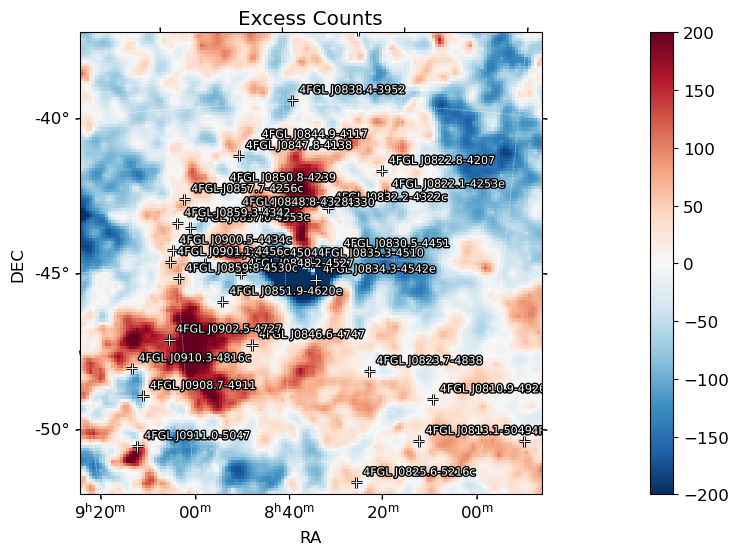

In [37]:
from fermipy.plotting import ROIPlotter
o = resid
fig = plt.figure(figsize=(14,6))
ROIPlotter(o['excess'],roi=gta.roi).plot(vmin=-200,vmax=200,cmap='RdBu_r')
plt.gca().set_title('Excess Counts')
plt.show()

In [38]:
tsmap = gta.tsmap('4FGL J0835-4510',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})

2023-06-05 11:03:52 INFO    GTAnalysis.tsmap(): Generating TS map
2023-06-05 11:04:15 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2023-06-05 11:07:11 INFO    GTAnalysis.tsmap(): Finished TS map
2023-06-05 11:07:23 WARNING GTAnalysis.tsmap(): Saving TS maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /data/PulsarTutorial/data/4FGL J0835-4510_pointsource_powerlaw_2.00_tsmap.npy
2023-06-05 11:07:23 INFO    GTAnalysis.tsmap(): Execution time: 211.27 s


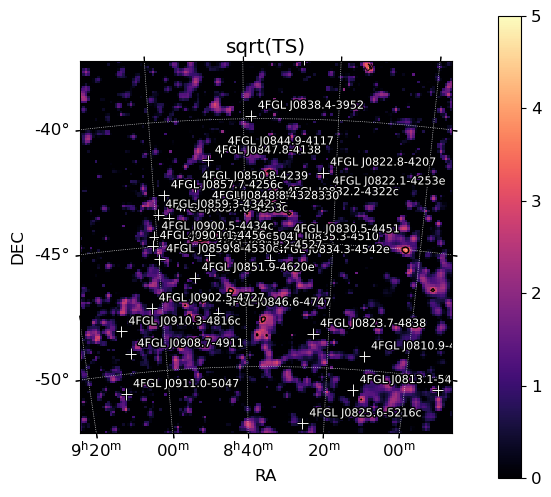

In [39]:
o = tsmap

fig = plt.figure(figsize=(6,6))
ROIPlotter(o['sqrt_ts'],roi=gta.roi).plot(vmin=0,vmax=5,levels=[3,5,7,9],subplot=111,cmap='magma')
plt.gca().set_title('sqrt(TS)')
plt.show()

In [41]:
resid_nogal = gta.residmap('PSR_J0835.3-4510_nogal',
                model={'SpatialModel' : 'PointSource', 'Index' : 2.0},
                exclude=['galdiff'])

2023-06-05 12:15:07 INFO    GTAnalysis.residmap(): Generating residual maps
2023-06-05 12:15:07 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2023-06-05 12:15:22 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2023-06-05 12:15:24 INFO    GTAnalysis.residmap(): Finished residual maps
2023-06-05 12:15:35 WARNING GTAnalysis.residmap(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /data/PulsarTutorial/data/PSR_J0835.3-4510_nogal_pointsource_powerlaw_2.00_residmap.npy
2023-06-05 12:15:35 INFO    GTAnalysis.residmap(): Execution time: 27.63 s


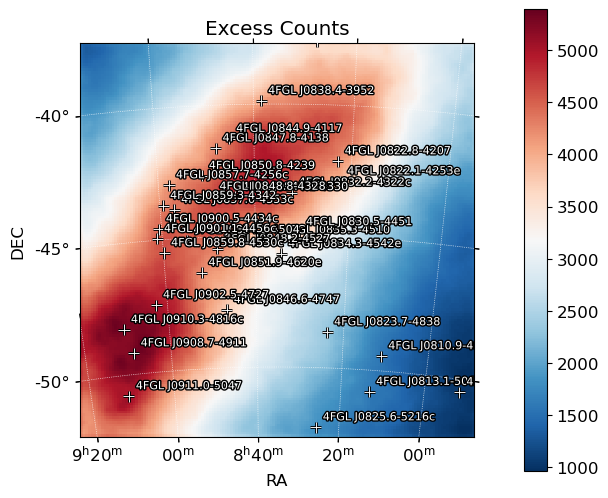

In [42]:
o = resid_nogal
fig = plt.figure(figsize=(14,6))
ROIPlotter(o['excess'],roi=gta.roi).plot(subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess Counts')
plt.show()

**Take a look at the spectral fit**

In [43]:
sed = gta.sed('4FGL J0835.3-4510')

2023-06-05 12:16:03 INFO    GTAnalysis.sed(): Computing SED for 4FGL J0835.3-4510
2023-06-05 12:17:08 INFO    GTAnalysis._make_sed(): Fitting SED
2023-06-05 12:17:08 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J0835.3-4510     : ['IndexS', 'ExpfactorS']
2023-06-05 12:17:08 INFO    GTAnalysis.free_source(): Fixing parameters for galdiff               : ['Index']
/opt/anaconda/envs/fermi/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2023-06-05 12:17:20 INFO    GTAnalysis.sed(): Finished SED
2023-06-05 12:17:30 INFO    GTAnalysis.sed(): Execution time: 87.20 s


In [44]:
source = gta.roi.get_source_by_name('4FGL J0835.3-4510')

In [45]:
E = np.array(source['model_flux']['energies'])
dnde = np.array(source['model_flux']['dnde'])
dnde_hi = np.array(source['model_flux']['dnde_hi'])
dnde_lo = np.array(source['model_flux']['dnde_lo'])

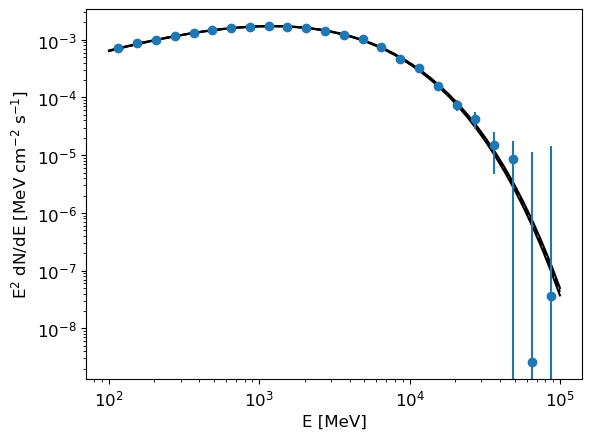

In [46]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(np.array(sed['e_ctr']),
             sed['e2dnde'], 
             yerr=sed['e2dnde_err'], fmt ='o')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

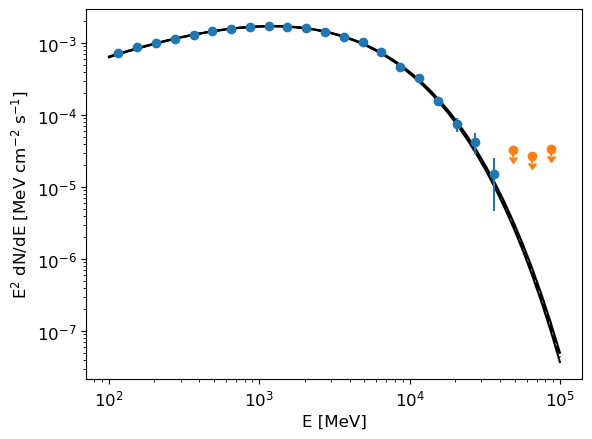

In [48]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(sed['e_ctr'][:-3],
             sed['e2dnde'][:-3], 
             yerr=sed['e2dnde_err'][:-3], fmt ='o')
plt.errorbar(np.array(sed['e_ctr'][-3:]),
         sed['e2dnde_ul95'][-3:], yerr=0.2*sed['e2dnde_ul95'][-3:], 
             fmt='o', uplims=True)
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

In [49]:
gta.write_roi('fit1_sed',make_plots=True)

2023-06-05 12:19:36 INFO    GTBinnedAnalysis.write_xml(): Writing /data/PulsarTutorial/data/fit1_sed_00.xml...
2023-06-05 12:19:37 INFO    GTBinnedAnalysis.write_xml(): Writing /data/PulsarTutorial/data/fit1_sed_01.xml...
2023-06-05 12:19:37 INFO    GTBinnedAnalysis.write_xml(): Writing /data/PulsarTutorial/data/fit1_sed_02.xml...
2023-06-05 12:19:37 INFO    GTBinnedAnalysis.write_xml(): Writing /data/PulsarTutorial/data/fit1_sed_03.xml...
2023-06-05 12:19:37 INFO    GTAnalysis.write_fits(): Writing /data/PulsarTutorial/data/fit1_sed.fits...
2023-06-05 12:19:54 INFO    GTAnalysis.write_roi(): Writing /data/PulsarTutorial/data/fit1_sed.npy...


**Iterate as needed**

If you want the process to run more quickly, you can loosen your tolerance by adding the "optimizer" parameter to your config.yaml file:

> optimizer:

> > tol : 0.01

However, that's not appropriate for a scientific result. The default tolerance is 0.001.

When you iterate, you should use the output model (fit1_00.xml) from this fit so that you are closer to the (hopefully) correct result. However, you will want to move any parameters that have hit their limits away from the limit value. 

Event Weighting
------------

Once the initial spectral analysis is complete, it is simple to run *[gtsrcprob](http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtsrcprob.txt)*. The tool generates a new file with additional columns, one for each source you specify in the *sourcelist.txt* file. It determines, for each photon, how likely it is for that photon to have originated from the sources and records that fractional probability in each column. Each photon row should have probabilities that add up to one for the listed sources.

Next you can use *[ftselect](http://heasarc.gsfc.nasa.gov/lheasoft/ftools/headas/ftselect.html)* to filter out events below a particular probability threshold of your choosing. Here we will use 20%. While this cut reduces the statistics for the search, it improves the signal to noise ratio and the chance of detecting significant pulsations.

***BE AWARE!!***
We will be selecting photons using a method that does not correct the GTIs or the exposure. This means that the resulting counts can't be used to measure the flux or spectral parameters of your source. Because we are searching for a temporal signature, this is not a concern for us.

Steps:
1. Use the photon filter tool (gtselect) to select a smaller region of photons around the source we want to analyze.
2. Apply the time filter (gtmktime)
3. Calculate the diffuse response for each photon
4. Calculate the probable association of the photon to each source in our sourcelist

In [51]:
import gt_apps
from gt_apps import *
filter['infile'] = '@events.txt'
filter['outfile'] = 'data/J0835_3deg_z90.fits'
filter['ra'] = 128.5
filter['dec'] = -45.83
filter['rad'] = 3
filter['tmin'] = 'INDEF'
filter['tmax'] = 'INDEF'
filter['emin'] = 300
filter['emax'] = 50000
filter['zmax'] = 90
filter['evclass'] = 128
filter.run()

time -p gtselect infile=@events.txt outfile=data/J0835_3deg_z90.fits ra=128.5 dec=-45.83 rad=3.0 tmin="INDEF" tmax="INDEF" emin=300.0 emax=50000.0 zmin=0.0 zmax=90.0 evclass=128 evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 14.32
user 1.04
sys 1.34


In [57]:
maketime['evfile'] = 'data/J0835_3deg_z90.fits'
maketime['outfile'] = 'data/J0835_3deg_z90_gti.fits'
maketime['scfile'] = 'data/SC00.fits'
maketime['filter'] = 'DATA_QUAL>0 && LAT_CONFIG==1'
maketime['apply_filter'] = 'yes'
maketime['roicut'] = 'yes'
maketime.run()

time -p gtmktime scfile=data/SC00.fits sctable="SC_DATA" filter="DATA_QUAL>0 && LAT_CONFIG==1" roicut=yes evfile=data/J0835_3deg_z90.fits evtable="EVENTS" outfile="data/J0835_3deg_z90_gti.fits" apply_filter=yes overwrite=no header_obstimes=yes tstart=0.0 tstop=0.0 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 3.28
user 1.12
sys 0.45


In [58]:
from astropy.io import fits as pyfits
original_data = pyfits.open('data/J0835_3deg_z90_gti.fits')
original_data.info()

Filename: data/J0835_3deg_z90_gti.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1  EVENTS        1 BinTableHDU    221   78649R x 23C   [E, E, E, E, E, E, E, E, E, D, J, J, I, 3I, 32X, 32X, I, D, E, E, E, E, E]   
  2  GTI           1 BinTableHDU     46   3752R x 2C   [D, D]   


Assigning probabilities to events is an inherently **UNBINNED** process. In order to do this, you will need the diffuse responses calculated for every event in your dataset. It's best to do this on the small region since the fit is already complete.

To add the diffuse responses, we run the *[gtdiffrsp](http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtdiffrsp.txt)* tool, using gtapps.

In [59]:
diffResps['evfile'] = 'data/J0835_3deg_z90_gti.fits'
diffResps['scfile'] = 'data/SC00.fits'
diffResps['srcmdl'] = 'data/fit1_00.xml'
diffResps['irfs'] = 'CALDB'
diffResps['evclass'] = 'INDEF'
diffResps['evtype'] = 'INDEF'
diffResps.run()

time -p gtdiffrsp evfile=data/J0835_3deg_z90_gti.fits evtable="EVENTS" scfile=data/SC00.fits sctable="SC_DATA" srcmdl=data/fit1_00.xml irfs="CALDB" evclsmin=0 evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=no debug=no gui=no mode="ql"
adding source 4FGL J0822.1-4253e
adding source 4FGL J0834.3-4542e
adding source 4FGL J0851.9-4620e
adding source galdiff
adding source isodiff
Working on...
data/J0835_3deg_z90_gti.fits.....................!
real 3992.43
user 3984.72
sys 2.09


*[gtsrcprob](http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtsrcprob.txt)* adds columns to your data file, rather than outputting a new, separate file. You should save a copy of the original data file before starting.

In [60]:
cp data/J0835_3deg_z90_gti.fits data/J0835_3deg_z90_gti.fits.bak

In [61]:
cat sourcelist.txt

4FGL J0835.3-4510
4FGL J0832.2-4322c


In [62]:
%system gtsrcprob \
  srclist=sourcelist.txt \
  evfile=data/J0835_3deg_z90_gti.fits \
  scfile=data/SC00.fits \
  outfile=data/J0835_3deg_z90_prob.fits \
  srcmdl=data/fit1_00.xml \
  irfs=P8R3_SOURCE_V3

[]

There are many ways to use the event probabilities. The most common are:
* Hard cuts
* Event weighting

Hard cuts remove any events with less than a specified probability of being attributed to the spectral model associated with your source. Here we are selecting a hard cut of 25%. You can play with this cut to see which value you think optimizes your results.

**NOTE:** We have to edit the output FITS file (J0835_3deg_z90_prob.fits) because *[ftselect](http://heasarc.gsfc.nasa.gov/lheasoft/ftools/headas/ftselect.html)* does not recognize column names containing a "+" symbol. It also doesn't like column names that begin with a number. Frustrating!

Event weighting uses the probability value to scale the influence that each event has on the results. That may be useful for some circumstances, but you can get the same effect for pulsars by using a phase-resolved analysis.

In [70]:
! ftselect \
  data/J0835_3deg_z90_prob.fits \
  data/J0835_3deg_z90_25percent.fits \
  '$4FGL J0835.3-4510$ > 0.25'

In [71]:
downselected_data = pyfits.open('data/J0835_3deg_z90_25percent.fits')
downselected_data.info()

Filename: data/J0835_3deg_z90_25percent.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1  EVENTS        1 BinTableHDU    225   77067R x 25C   [E, E, E, E, E, E, E, E, E, D, J, J, I, 3I, 32X, 32X, I, D, E, E, E, E, E, 1E, 1E]   
  2  GTI           1 BinTableHDU     46   3752R x 2C   [D, D]   


Apply the Timing Model
------------------

Once you have purified your event list, you can apply the radio timing model to see if there are significant gamma-ray pulsations. This is best performed in tempo2, using the user-contributed [tempo2](http://fermi.gsfc.nasa.gov/ssc/data/analysis/user/Fermi_plug_doc.pdf) plugin. 

The *tempo2* plugin does not provide any pulse search capability. It simply applies the radio timing model to the gamma-ray data, and then plots the results, including the H-test result. The tool also assigns phase values to the events in the LAT data file. 

Let's investigate what's available with tempo2:

In [72]:
! tempo2 -h

This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under conditions of GPL license.


Tempo2 2021.06.1

examples: tempo2 mytim.tim
          tempo2 -f mypar.par mytim.tim
          tempo2 -gr plk -f mypar.par mytim.tim

Options: 

-f parFile        Selects parameter file
-epoch centre     Centres the PEPOCH in the fit
-dcf model        Enable Generalised Least Squares using given model file
-gr name          Uses 'name' plugin for graphical interface
-h                This help
-list             Provides listing of clock corrections and residuals etc.
-output name      Uses 'name' plugin for output format
-pred "args"    Creates a predictive 2D Chebyshev polynomial.
      args = "sitename mjd1 mjd2 freq1 freq2 ntimecoeff nfreqcoeff seg_length (s)"
-polyco "args"  Creates a TEMPO1-style polyco file.
                   args = "mjd1 mjd2 nspan ncoeff maxha sitename freq"
-polyco_file      Specify a leading string for file outputs.

The tempo2 command is:

In [73]:
! tempo2 -gr fermi -ft1 data/J0835_3deg_z90_25percent.fits -ft2 data/SC00.fits -f J0835-4510_54683_56587_chol.par -phase

This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under conditions of GPL license.

Looking for /home/fermi/astrosoft/tempo2/T2runtime/plugins//fermi_linux-gnu_plug.t2

------------------------------------------
Output interface:    fermi
Author:              Lucas Guillemot
Updated:             6 April 2020
Version:             6.3
------------------------------------------

First photon date in FT1: 239562835.571697 MET (s)
 Last photon date in FT1: 255396942.545996 MET (s)

Adding new column PULSE_PHASE.

First START date in FT2:  239557417.494176 MET (s)
 Last START date in FT2:  255398428.600000 MET (s)

[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. J0835-4510_54683_56587_chol.par

[tabulatedfunction.C:84] Warning: Error parsing file /home/fermi/astrosoft/tempo2/T2runtime/clock/ncyobs2obspm.clk: Entry 3815 out of order 50822.572920 < 50823.156253
[tabulatedfunction.C:84

![J0248_tempo2_out.png](images/J0248_tempo2_out.png)

As you can see, the H-test for this source is about 350. Anything over 25 is considered a detection.

![PSRJ0248+6021_2PC_LC.png](SecondPulsarCatalogFIles/2PC_auxiliary_files_v04/images/lightcurves/PNG/PSRJ0248+6021_2PC_LC.png)

Divide up Data by Phase
------------------

You can now separate your dataset into two parts, the ON-pulse or OFF-pulse phases. Take a look at the divided data to see how effective the split is at removing the pulsar.

In [74]:
! punlearn gtselect

In [75]:
filter['infile'] = '@data/events.txt'
filter['outfile'] = 'data/J0835_all_z90.fits'
filter['ra'] = 'INDEF'
filter['dec'] = 'INDEF'
filter['rad'] = 'INDEF'
filter['tmin'] = 'INDEF'
filter['tmax'] = 'INDEF'
filter['emin'] = 300
filter['emax'] = 50000
filter['zmax'] = 90
filter['evclass'] = 128
filter['phasemin'] = 0
filter['phasemax'] = 1
filter.run()

time -p gtselect infile=@data/events.txt outfile=data/J0835_all_z90.fits ra="INDEF" dec="INDEF" rad="INDEF" tmin="INDEF" tmax="INDEF" emin=300.0 emax=50000.0 zmin=0.0 zmax=90.0 evclass=128 evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Caught N3tip12TipExceptionE at the top level: File not found: L2306042305074ABB9C6321_PH00.fits


RuntimeError: gtselect execution failed

In [47]:
maketime['evfile'] = 'data/J0248_all_z90.fits'
maketime['outfile'] = 'data/J0248_all_z90_gti.fits'
maketime['scfile'] = 'data/SC00.fits'
maketime['filter'] = 'DATA_QUAL>0 && LAT_CONFIG==1'
maketime['apply_filter'] = 'yes'
maketime['roicut'] = 'yes'
maketime.run()

time -p /usr/local/fermisoft/v10r0p5-fssc-20150518A/x86_64-unknown-linux-gnu-libc2.17/bin/gtmktime scfile=data/SC00.fits sctable="SC_DATA" filter="DATA_QUAL>0 && LAT_CONFIG==1" roicut=yes evfile=data/J0248_all_z90.fits evtable="EVENTS" outfile="data/J0248_all_z90_gti.fits" apply_filter=yes overwrite=no header_obstimes=yes tstart=0.0 tstop=0.0 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 24.04
user 22.95
sys 0.50


In [49]:
%system tempo2 -gr fermi -ft1 data/J0248_all_z90_gti.fits -ft2 data/SC00.fits -f PSRJ0248+6021_2PC.par -phase

['This program comes with ABSOLUTELY NO WARRANTY.',
 'This is free software, and you are welcome to redistribute it',
 'under conditions of GPL license.',
 '',
 'Looking for /usr/local/share/tempo2//plugins//fermi_linux-gnu_plug.t2',
 '',
 '------------------------------------------',
 'Output interface:    fermi',
 'Author:              Lucas Guillemot',
 'Updated:             10 April 2017',
 'Version:             6.0',
 '------------------------------------------',
 '',
 'First photon date in FT1: 239557525.705004 MET (s)',
 ' Last photon date in FT1: 335141747.874831 MET (s)',
 '',
 'Adding new column PULSE_PHASE.',
 '',
 'First START date in FT2:  239557417.494176 MET (s)',
 ' Last START date in FT2:  335144326.600000 MET (s)',
 '',
 'WARNING: large FT1 file, turning off graphical output.',
 'Treating events # 1 to 10000... ',
 'Treating events # 10001 to 20000... ',
 'Treating events # 20001 to 30000... ',
 'Treating events # 30001 to 40000... ',
 'Treating events # 40001 to 5000

In [50]:
filter['infile'] = 'data/J0248_all_z90_gti.fits'
filter['outfile'] = 'data/J0248_ONpulse_z90.fits'
filter['ra'] = 'INDEF'
filter['dec'] = 'INDEF'
filter['rad'] = 'INDEF'
filter['tmin'] = 'INDEF'
filter['tmax'] = 'INDEF'
filter['emin'] = 300
filter['emax'] = 50000
filter['zmax'] = 90
filter['evclass'] = 128
filter['phasemin'] = 0.3
filter['phasemax'] = 0.5
filter.run()

time -p /usr/local/fermisoft/v10r0p5-fssc-20150518A/x86_64-unknown-linux-gnu-libc2.17/bin/gtselect infile=data/J0248_all_z90_gti.fits outfile=data/J0248_ONpulse_z90.fits ra="INDEF" dec="INDEF" rad="INDEF" tmin="INDEF" tmax="INDEF" emin=300.0 emax=50000.0 zmin=0.0 zmax=90.0 evclass=128 evclsmin=0 evclsmax=10 evtype="INDEF" convtype=-1 phasemin=0.3 phasemax=0.5 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 1.66
user 1.16
sys 0.11


In [64]:
onpulse_data = pyfits.open('data/J0248_ONpulse_z90.fits')
onpulse_data.info()

Filename: data/J0248_ONpulse_z90.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      36   ()      
  1  EVENTS      BinTableHDU    236   139814R x 24C   [E, E, E, E, E, E, E, E, E, D, J, J, I, 3I, 32X, 32X, I, D, E, E, E, E, E, 1D]   
  2  GTI         BinTableHDU     46   15564R x 2C   [D, D]   


In [53]:
counts_map['evfile'] = 'data/J0248_ONpulse_z90.fits'
counts_map['scfile'] = 'NONE'
counts_map['outfile'] = 'data/J0248_ONpulse_z90_cmap.fits'
counts_map['algorithm'] = 'CMAP'
counts_map['xref'] = 42.0777
counts_map['yref'] = 60.3595
counts_map['coordsys'] = 'CEL'
counts_map['nxpix'] = 300
counts_map['nypix'] = 300
counts_map['binsz'] = 0.1
counts_map['axisrot'] = 0.0
counts_map['proj'] = 'AIT'
counts_map.run()

time -p /usr/local/fermisoft/v10r0p5-fssc-20150518A/x86_64-unknown-linux-gnu-libc2.17/bin/gtbin evfile=data/J0248_ONpulse_z90.fits scfile=NONE outfile=data/J0248_ONpulse_z90_cmap.fits algorithm="CMAP" ebinalg="LOG" emin=30.0 emax=200000.0 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=300 nypix=300 binsz=0.1 coordsys="CEL" xref=42.0777 yref=60.3595 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version ScienceTools-v10r0p5-fssc-20150518
gtbin: WARNING: No spacecraft file: EXPOSURE keyword will be set equal to ontime.
real 0.41
user 0.36
sys 0.04


Because the OFF-pulse data are in two segments, we have to filter them using ftselect.

However, remember that when running a new spectral analysis, you cannot combine the resulting files. This means that you will need fermipy to treat the two different phase cuts as separate components.

In [61]:
%system ftselect 'data/J0248_all_z90_gti.fits[events]' data/J0248_OFFpulse_z90.fits '(PULSE_PHASE > 0 && PULSE_PHASE < 0.25) || (PULSE_PHASE > 0.6 && PULSE_PHASE < 1)'

['ERROR: No such device or address',
 'Task ftselect 0.0 terminating with status 6',
 'Unable to redirect prompts to the /dev/tty (at headas_stdio.c:152)']

In [65]:
offpulse_data = pyfits.open('data/J0248_OFFpulse_z90.fits')
offpulse_data.info()

Filename: data/J0248_OFFpulse_z90.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      36   ()      
  1  EVENTS      BinTableHDU    224   450838R x 24C   [E, E, E, E, E, E, E, E, E, D, J, J, I, 3I, 32X, 32X, I, D, E, E, E, E, E, 1D]   
  2  GTI         BinTableHDU     46   15564R x 2C   [D, D]   


In [63]:
counts_map['evfile'] = 'data/J0248_OFFpulse_z90.fits'
counts_map['scfile'] = 'NONE'
counts_map['outfile'] = 'data/J0248_OFFpulse_z90_cmap.fits'
counts_map['algorithm'] = 'CMAP'
counts_map['xref'] = 42.0777
counts_map['yref'] = 60.3595
counts_map['coordsys'] = 'CEL'
counts_map['nxpix'] = 300
counts_map['nypix'] = 300
counts_map['binsz'] = 0.1
counts_map['axisrot'] = 0.0
counts_map['proj'] = 'AIT'
counts_map.run()

time -p /usr/local/fermisoft/v10r0p5-fssc-20150518A/x86_64-unknown-linux-gnu-libc2.17/bin/gtbin evfile=data/J0248_OFFpulse_z90.fits scfile=NONE outfile=data/J0248_OFFpulse_z90_cmap.fits algorithm="CMAP" ebinalg="LOG" emin=30.0 emax=200000.0 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=300 nypix=300 binsz=0.1 coordsys="CEL" xref=42.0777 yref=60.3595 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version ScienceTools-v10r0p5-fssc-20150518
gtbin: WARNING: No spacecraft file: EXPOSURE keyword will be set equal to ontime.
real 0.85
user 0.79
sys 0.05


__ON-Pulse__
![ON-pulse](images/J0248_ONpulse.png)
__OFF-Pulse__
![OFF-pulse](images/J0248_OFFpulse.png)

Phase-Resolved Analysis
------------------

Your next step is probably a spectral analysis using either only the ON-pulse or OFF-pulse events. Once you have a PULSE_PHASE column in your events file, fermipy provides an easy method to analyze data by phase range.

For a single-peaked pulsar like this one, you can add the ***phasemin*** and ***phasemax*** parameters to the ***selection*** portion of your config.yaml file. 

(I renamed my config.yaml to config_ON.yaml and config_OFF for this purpose. I also created new data files to contain the new data files.)

In [71]:
cat config_ON.yaml

data:

  evfile : /home/vagrant/PSR_analysis/data_ON/J0248_ONpulse_z90.fits
  scfile : /home/vagrant/PSR_analysis/data/SC00.fits

binning:
  roiwidth   : 15.0
  binsz      : 0.1
  binsperdec : 8

selection :
  emin : 100
  emax : 100000
  zmax    : 90
  evclass : 128
  evtype  : 3
  tmin    : 239557417
  tmax    : 335145602
  filter  : null
  target : 'PSR J0248+6021'
  phasemin : 0.3
  phasemax : 0.5

gtlike:
  edisp : True
  irfs : 'P8R2_SOURCE_V6'
  edisp_disable : ['isodiff','galdiff']

model:
  src_roiwidth : 20.0
  galdiff  : '/vagrant/gll_iem_v06.fits'
  isodiff  : 'iso_P8R2_SOURCE_V6_v06.txt'
  catalogs : ['3FGL']

optimizer:
  tol : 0.01

fileio:
   outdir : data_ON


If you have a multi-peaked pulsar, or to analyze the OFF-pulse region, you will need to analyze multiple components at the same time. To do this, I moved the ***selection*** information into the ***components*** area of my config_OFF.yaml file.

In [72]:
cat config_OFF.yaml

data:
  evfile : /home/vagrant/PSR_analysis/data_OFF/J0248_OFFpulse_z90.fits
  scfile : /home/vagrant/PSR_analysis/data/SC00.fits

binning:
  roiwidth   : 15.0
  binsz      : 0.1
  binsperdec : 8

selection :
  emin : 100
  emax : 100000
  zmax    : 90
  evclass : 128
  evtype  : 3
  tmin    : 239557417
  tmax    : 335145602
  filter  : null
  target : 'PSR J0248+6021'

gtlike:
  edisp : True
  irfs : 'P8R2_SOURCE_V6'
  edisp_disable : ['isodiff','galdiff']

model:
  src_roiwidth : 20.0
  galdiff  : '/vagrant/gll_iem_v06.fits'
  isodiff  : 'iso_P8R2_SOURCE_V6_v06.txt'
  catalogs : ['3FGL']

optimizer:
  tol : 0.01

components:
#  - { selection : { phasemin : 0.0, phasemax : 0.25 } } # off-pulse 1
#  - { selection : { phasemin : 0.6, phasemax : 1.0 } } # off-pulse 2

fileio:
   outdir : data_OFF


Then you run a spectral fit as above, but with the portion of the data that you are interested in. 

ON-Pulse
--------

In [73]:
gta_ON = GTAnalysis('config_ON.yaml',logging={'verbosity' : 3})

2017-06-03 17:38:36 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 0.14.1 
ScienceTools version 


In [74]:
gta_ON.setup()

2017-06-03 17:38:48 INFO    GTAnalysis.setup(): Running setup.
2017-06-03 17:38:48 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2017-06-03 17:38:48 INFO    GTBinnedAnalysis.run_gtapp(): Running gtselect.
2017-06-03 17:38:48 INFO    GTBinnedAnalysis.run_gtapp(): time -p /usr/local/fermisoft/v10r0p5-fssc-20150518A/x86_64-unknown-linux-gnu-libc2.17/bin/gtselect infile=/home/vagrant/PSR_analysis/data_ON/J0248_ONpulse_z90.fits outfile=/home/vagrant/PSR_analysis/data_ON/ft1_00.fits ra=42.1469993591 dec=60.3725013733 rad=11.1066017178 tmin=239557417.0 tmax=335145602.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=90.0 evclass=128 evclsmin=0 evclsmax=10 evtype=3 convtype=-1 phasemin=0.3 phasemax=0.5 evtable="EVENTS" chatter=3 clobber=yes debug=no gui=no mode="ql"
2017-06-03 17:38:49 INFO    GTBinnedAnalysis.run_gtapp(): This is gtselect version ScienceTools-v10r0p5-fssc-20150518
2017-06-03 17:38:49 INFO    GTBinnedAnalysis.run_gtapp(): Applying filter string: ((EVENT_CLASS&o200) !

KeyboardInterrupt: 

In [ ]:
opt2_ON = gta_ON.optimize()

In [ ]:
gta_ON.print_roi()

In [ ]:
deleted_sources_ON = gta_ON.delete_sources(minmax_ts=[-1,1])

In [ ]:
gta_ON.print_roi()

In [ ]:
# Free Normalization of all Sources within 3 deg of ROI center
gta_ON.free_sources(distance=3.0,pars='norm')

# Free sources with TS > 10
gta_ON.free_sources(minmax_ts=[10,None],pars='norm')

# Free all parameters of isotropic and galactic diffuse components
gta_ON.free_source('galdiff')
gta_ON.free_source('isodiff')

In [ ]:
fit2_ON = gta_ON.fit()

In [ ]:
gta_ON.print_roi()

In [ ]:
print(gta_ON.roi['3FGL J0248.5+6022'])

An SED of the on-pulse data should give you the best information for the pulsar itself:

In [ ]:
sed_ON = gta_ON.sed('PSR J0248+6021')

In [ ]:
PSR_ON = gta_ON.roi.get_source_by_name('3FGL J0248+6022')

In [ ]:
E = np.array(PSR_ON['model_flux']['energies'])
dnde = np.array(PSR_ON['model_flux']['dnde'])
dnde_hi = np.array(PSR_ON['model_flux']['dnde_hi'])
dnde_lo = np.array(PSR_ON['model_flux']['dnde_lo'])

In [ ]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(np.array(sed['e_ctr']),
             sed['e2dnde'], 
             yerr=sed['e2dnde_err'], fmt ='o')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

In [ ]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(sed['e_ctr'][:-4],
             sed['e2dnde'][:-4], 
             yerr=sed['e2dnde_err'][:-4], fmt ='o')
plt.errorbar(np.array(sed['e_ctr'][-4:]),
         sed['e2dnde_ul95'][-4:], yerr=0.2*sed['e2dnde_ul95'][-4:], 
             fmt='o', uplims=True)
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

In [ ]:
gta_ON.write_roi('fit2_ON_sed',make_plots=True)

Compare this output SED with the previous one to see how removing the off-pulse emission and reducing the influence of the other sources has improved the fit.

OFF-Pulse
--------

An OFF-pulse analysis make it possible to analyze faint sources near a bright pulsar by using the timing information to effectively turn the pulsar off. 

In [ ]:
gta_OFF = GTAnalysis('config_OFF.yaml',logging={'verbosity' : 3})

In [ ]:
gta_OFF.setup()

In [ ]:
opt3_OFF = gta_OFF.optimize()

In [ ]:
gta_OFF.print_roi()

In [ ]:
deleted_sources_OFF = gta_OFF.delete_sources(minmax_ts=[-1,1])

In [ ]:
gta_OFF.print_roi()

In [ ]:
# Free Normalization of all Sources within 3 deg of ROI center
gta_OFF.free_sources(distance=3.0,pars='norm')

# Free sources with TS > 10
gta_OFF.free_sources(minmax_ts=[10,None],pars='norm')

# Free all parameters of isotropic and galactic diffuse components
gta_OFF.free_source('galdiff')
gta_OFF.free_source('isodiff')

In [ ]:
fit3_OFF = gta_OFF.fit()

In [ ]:
gta_OFF.print_roi()

In [ ]:
print(gta_OFF.roi['3FGL J0248.5+6022'])

Yup, there's not much left of the pulsar!

Now let's compare the results from the nearby bright source to the original analaysis...

In [ ]:
print(gta.roi['3FGL J0240.5+6113'])

In [ ]:
print(gta_OFF.roi['3FGL J0240.5+6113'])

This source's OFF-pulse result looks different from the previous fit. This is because the Likelihood analysis does not take the phase cut into account. You will need to manually scale the output by the fraction of data that was removed to get the real value for the fit.

In this case, the OFF-pulse was 0.0 - 0.25 and 0.6 - 1.0, or 65% of the full dataset. this means you need to multiply the resulting values by 100/65, or ~1.54, to get the equivalent full flux for this source.

Phase-Resolved Light Curves
----------

If you want to do a lightcurve of the pulsar's ON-pulse contribution, or of a source in the OFF-pulse data, you should do the phase-resolved spectral fit first and use the resulting object to generate your lightcurve.